# GRU_Airline

In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

# %%
#Normalization  
def feature_normalize(train):
    train_norm = train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))  #標準化(介於0~1之間)
    return train_norm


## 很重要  切割視窗
def create_segments_and_labels(df, time_steps, step):

    N_FEATURES = 1
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps-1, step):
        xs = df.values[i: i + time_steps]
        rate = (df.values[i + time_steps]-df.values[i + time_steps-1])/df.values[i + time_steps-1]
        #rate = df.values[i + time_steps]-df.values[i + time_steps-1]
        temp = rate
        if temp < 0:
            if temp <= -0.2:
                label =0
            elif temp <= -0.1:
                label =1
            elif temp < 0:
                label =2
        else:
            if temp == 0:
                label =3
            elif temp <= 0.1:
                label =4
            elif temp <= 0.2:
                label =5                
            elif temp >0.2:
                label =6              
 
        segments.append([xs])
        labels.append([label])

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


Using TensorFlow backend.


In [2]:
# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# The number of steps within one time segment
TIME_PERIODS = 12
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 1

# %%

print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = pd.read_csv('D:/Value of Dream/108-1 深度學習/Deep Learning Tool/Data/airline.csv',encoding='Big5')    #編碼為Big5
cols=['passenger']       #命名欄位
df =df[cols]                                      #將欄位名稱放入資料中          


# %%

print("\n--- Reshape the data into segments ---\n")

# Normalize features for training data set
df_train= feature_normalize(df)

x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS, STEP_DISTANCE)

# %%

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')

print('y_train shape: ', y_train.shape)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = 7


# Set input_shape / reshape for Keras
input_shape = (num_time_periods*num_sensors)   
x_train = x_train.reshape(x_train.shape[0], input_shape)   

print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# %%

# One-hot encoding of y_train labels (only execute once!)
y_train_oneshot = np_utils.to_categorical(y_train, num_classes)


## 分成訓練跟測試
x_train_used = x_train[0:120,]
y_train_used_oneshot = y_train_oneshot[0:120,]
x_test_used = x_train[121:,]
y_test_used_oneshot = y_train_oneshot[121:,]

print("\n--- Create neural network model ---\n")



--- Load, inspect and transform data ---


--- Reshape the data into segments ---


--- Reshape data to be accepted by Keras ---

x_train shape:  (131, 12, 1)
131 training samples
y_train shape:  (131, 1)
x_train shape: (131, 12)
input_shape: 12

--- Create neural network model ---



In [4]:

# from 2 dimmension to 3 dimension


x_train_used = x_train_used[:,:,np.newaxis]
x_test_used = x_test_used[:,:,np.newaxis]


###########################################

#一對一模型
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, GRU
from keras.layers import SimpleRNN, Activation, Dense, RNN
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

## build one To One Model(shape):
model = Sequential()
##  GRU  注意他的 input 格式!!
#Units:cell 個數
model.add(GRU(units=128, input_shape=( x_train_used.shape[1], x_train_used.shape[2])))#12,1
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

print("\n--- Fit the model ---\n")

train_history = model.fit(x=x_train_used, y= y_train_used_oneshot, validation_split=0.1, epochs=550, batch_size=10, verbose=2)


print("\n--- Learning curve of model training ---\n")


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               49920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_3 (Dropout)  

Epoch 72/550
 - 0s - loss: 1.3999 - acc: 0.3611 - val_loss: 2.0484 - val_acc: 0.4167
Epoch 73/550
 - 0s - loss: 1.3683 - acc: 0.4722 - val_loss: 1.3516 - val_acc: 0.4167
Epoch 74/550
 - 0s - loss: 1.3782 - acc: 0.3889 - val_loss: 1.7170 - val_acc: 0.4167
Epoch 75/550
 - 0s - loss: 1.3883 - acc: 0.3796 - val_loss: 1.3364 - val_acc: 0.4167
Epoch 76/550
 - 0s - loss: 1.3181 - acc: 0.4167 - val_loss: 1.7386 - val_acc: 0.3333
Epoch 77/550
 - 0s - loss: 1.3424 - acc: 0.4352 - val_loss: 1.6539 - val_acc: 0.2500
Epoch 78/550
 - 0s - loss: 1.3701 - acc: 0.4074 - val_loss: 1.5216 - val_acc: 0.3333
Epoch 79/550
 - 0s - loss: 1.3260 - acc: 0.4167 - val_loss: 1.1773 - val_acc: 0.4167
Epoch 80/550
 - 0s - loss: 1.3619 - acc: 0.3889 - val_loss: 2.0399 - val_acc: 0.4167
Epoch 81/550
 - 0s - loss: 1.3180 - acc: 0.4630 - val_loss: 1.4724 - val_acc: 0.3333
Epoch 82/550
 - 0s - loss: 1.3128 - acc: 0.4167 - val_loss: 1.2265 - val_acc: 0.4167
Epoch 83/550
 - 0s - loss: 1.3129 - acc: 0.4167 - val_loss: 1.315

Epoch 168/550
 - 0s - loss: 0.9549 - acc: 0.6019 - val_loss: 1.2980 - val_acc: 0.8333
Epoch 169/550
 - 0s - loss: 0.9023 - acc: 0.5926 - val_loss: 1.1264 - val_acc: 0.8333
Epoch 170/550
 - 0s - loss: 0.9100 - acc: 0.6019 - val_loss: 1.4124 - val_acc: 0.6667
Epoch 171/550
 - 0s - loss: 1.2159 - acc: 0.4907 - val_loss: 1.2632 - val_acc: 0.5833
Epoch 172/550
 - 0s - loss: 1.1149 - acc: 0.5278 - val_loss: 1.7366 - val_acc: 0.5833
Epoch 173/550
 - 0s - loss: 0.9476 - acc: 0.6019 - val_loss: 1.2308 - val_acc: 0.7500
Epoch 174/550
 - 0s - loss: 0.9410 - acc: 0.6111 - val_loss: 1.2299 - val_acc: 0.7500
Epoch 175/550
 - 0s - loss: 0.9014 - acc: 0.6481 - val_loss: 1.2050 - val_acc: 0.6667
Epoch 176/550
 - 0s - loss: 0.9041 - acc: 0.6019 - val_loss: 1.2413 - val_acc: 0.6667
Epoch 177/550
 - 0s - loss: 0.8883 - acc: 0.6574 - val_loss: 1.5601 - val_acc: 0.6667
Epoch 178/550
 - 0s - loss: 0.8669 - acc: 0.6574 - val_loss: 1.6912 - val_acc: 0.7500
Epoch 179/550
 - 0s - loss: 0.8404 - acc: 0.6481 - val

Epoch 264/550
 - 0s - loss: 0.5871 - acc: 0.7685 - val_loss: 1.4811 - val_acc: 0.7500
Epoch 265/550
 - 0s - loss: 0.6156 - acc: 0.7130 - val_loss: 1.6400 - val_acc: 0.7500
Epoch 266/550
 - 0s - loss: 0.6699 - acc: 0.7130 - val_loss: 1.4105 - val_acc: 0.7500
Epoch 267/550
 - 0s - loss: 0.5865 - acc: 0.7685 - val_loss: 1.5219 - val_acc: 0.6667
Epoch 268/550
 - 0s - loss: 0.6217 - acc: 0.7315 - val_loss: 1.4048 - val_acc: 0.7500
Epoch 269/550
 - 0s - loss: 0.7131 - acc: 0.6759 - val_loss: 1.3092 - val_acc: 0.7500
Epoch 270/550
 - 0s - loss: 0.6741 - acc: 0.7222 - val_loss: 1.2248 - val_acc: 0.7500
Epoch 271/550
 - 0s - loss: 0.5852 - acc: 0.7130 - val_loss: 1.2021 - val_acc: 0.6667
Epoch 272/550
 - 0s - loss: 0.6186 - acc: 0.7778 - val_loss: 1.3864 - val_acc: 0.7500
Epoch 273/550
 - 0s - loss: 0.6207 - acc: 0.7037 - val_loss: 1.3864 - val_acc: 0.7500
Epoch 274/550
 - 0s - loss: 0.6163 - acc: 0.7037 - val_loss: 1.4555 - val_acc: 0.7500
Epoch 275/550
 - 0s - loss: 0.6007 - acc: 0.7593 - val

Epoch 360/550
 - 0s - loss: 0.4075 - acc: 0.8611 - val_loss: 1.5453 - val_acc: 0.7500
Epoch 361/550
 - 0s - loss: 0.4728 - acc: 0.8426 - val_loss: 1.4158 - val_acc: 0.7500
Epoch 362/550
 - 0s - loss: 0.3980 - acc: 0.8426 - val_loss: 1.3276 - val_acc: 0.7500
Epoch 363/550
 - 0s - loss: 0.4313 - acc: 0.8333 - val_loss: 1.3215 - val_acc: 0.7500
Epoch 364/550
 - 0s - loss: 0.4483 - acc: 0.8241 - val_loss: 1.4459 - val_acc: 0.7500
Epoch 365/550
 - 0s - loss: 0.4628 - acc: 0.8056 - val_loss: 1.3225 - val_acc: 0.7500
Epoch 366/550
 - 0s - loss: 0.4249 - acc: 0.8519 - val_loss: 1.4905 - val_acc: 0.7500
Epoch 367/550
 - 0s - loss: 0.3584 - acc: 0.8796 - val_loss: 1.6375 - val_acc: 0.7500
Epoch 368/550
 - 0s - loss: 0.4139 - acc: 0.8148 - val_loss: 1.8002 - val_acc: 0.7500
Epoch 369/550
 - 0s - loss: 0.3947 - acc: 0.8704 - val_loss: 1.5703 - val_acc: 0.6667
Epoch 370/550
 - 0s - loss: 0.3744 - acc: 0.8519 - val_loss: 1.1634 - val_acc: 0.7500
Epoch 371/550
 - 0s - loss: 0.3543 - acc: 0.8426 - val

Epoch 456/550
 - 0s - loss: 0.2841 - acc: 0.9074 - val_loss: 0.9381 - val_acc: 0.7500
Epoch 457/550
 - 0s - loss: 0.3442 - acc: 0.8889 - val_loss: 1.0834 - val_acc: 0.7500
Epoch 458/550
 - 0s - loss: 0.2655 - acc: 0.8889 - val_loss: 1.1510 - val_acc: 0.7500
Epoch 459/550
 - 0s - loss: 0.2621 - acc: 0.8796 - val_loss: 1.0372 - val_acc: 0.7500
Epoch 460/550
 - 0s - loss: 0.2327 - acc: 0.9074 - val_loss: 0.9398 - val_acc: 0.8333
Epoch 461/550
 - 0s - loss: 0.2856 - acc: 0.8704 - val_loss: 1.1566 - val_acc: 0.7500
Epoch 462/550
 - 0s - loss: 0.2888 - acc: 0.9074 - val_loss: 1.3375 - val_acc: 0.7500
Epoch 463/550
 - 0s - loss: 0.2754 - acc: 0.8889 - val_loss: 1.3652 - val_acc: 0.7500
Epoch 464/550
 - 0s - loss: 0.2653 - acc: 0.8889 - val_loss: 1.3132 - val_acc: 0.7500
Epoch 465/550
 - 0s - loss: 0.2503 - acc: 0.9167 - val_loss: 1.3212 - val_acc: 0.7500
Epoch 466/550
 - 0s - loss: 0.3191 - acc: 0.8889 - val_loss: 1.2712 - val_acc: 0.7500
Epoch 467/550
 - 0s - loss: 0.2275 - acc: 0.9259 - val

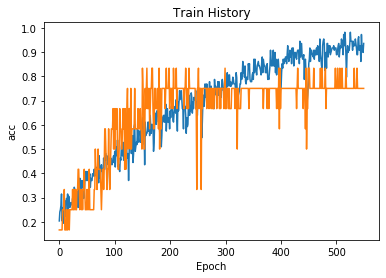

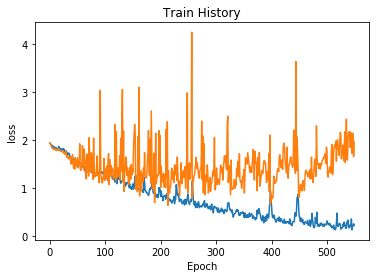

10/10 [==============================] - 0s 195us/step
Accuracy: 0.5%


array([[0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0]], dtype=int64)

In [5]:
get_ipython().magic('matplotlib inline')
## IPython有一組預先定義好的所謂的魔法函數（Magic Functions），你可以通過命令列的語法形式來訪問它們。

import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.show()

show_train_history(train_history, "acc", "val_acc") ## 訓練正確率圖

show_train_history(train_history, "loss", "val_loss") ## 訓練誤差圖

###############################


scores = model.evaluate(x_test_used, y_test_used_oneshot)

print("Accuracy: {}%".format(scores[1]))


results = model.predict_classes(x_test_used)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train[121:,], results)
cm


